y=104.24*sin(0.49x + 4.01) + -35.05


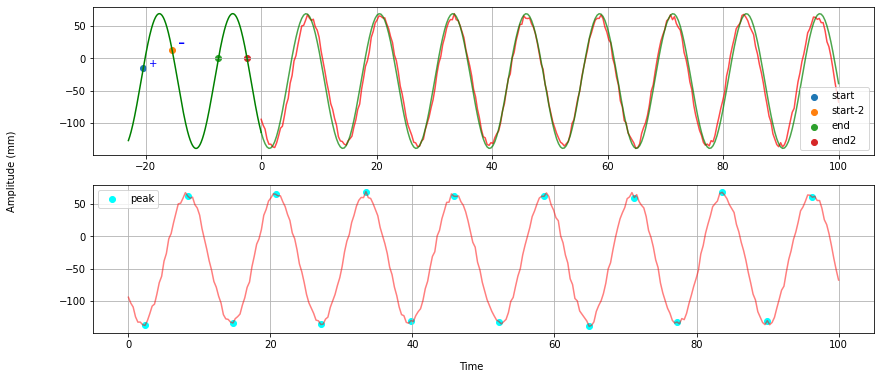

In [16]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import statsmodels.api as sm
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

class SinEstimator:
    def __init__(self, xs, ys):
        self.xs = np.array(xs)
        self.ys = np.array(ys)
        self.A, self.T, self.B, self.C = self.find_ATBC(self.xs, self.ys)
        print(f"y={self.A:.2f}*sin({self.T:.2f}x + {self.C:.2f}) + {self.B:.2f}")

    def find_peaks_opt(self, y):
        x_values = np.arange(len(y))
        y = sm.nonparametric.lowess(y, x_values, frac=0.05)[:, 1]
        peaks1, _ = find_peaks(y, prominence=2) 
        peaks2, _ = find_peaks(-y, prominence=2) 
        peaks = np.concatenate([peaks1, peaks2], axis=0)
        peaks.sort()
        return peaks

    def find_ATB(self, x, y):
        peaks = self.find_peaks_opt(y)
        x_p = x[peaks]
        y_p = y[peaks]
        A = np.ptp(y_p)/2
        B = (y_p.max() + y_p.min())/2
        period = np.median(np.diff(x_p))*2
        T = 2*np.pi/period
        return A, T, B

    def find_C(self, x, y, A, T, B):
        def sinf(x, C):
            return A*np.sin(T*x + C) + B
        params, covs = curve_fit(sinf, x, y)
        return params[0]

    def find_ATBC(self, x, y):
        A, T, B = self.find_ATB(x, y)
        C = self.find_C(x, y, A, T, B)
        return A, T, B, C

    def solve_t(self, dt):
        # solve 0  = A*sin(T*(x + dt) + C) + B
        # np.arcsin returns value from -pi/2 to pi/2
        v1 = np.arcsin(-self.B/self.A)
        v2 = np.sign(v1)*np.pi - v1
        t1 = (v1 -self.C)/self.T - dt
        t2 = (v2 -self.C)/self.T - dt
        # validate the solution
        # y1 = f(t1+dt, A, B, T)
        # y2 = f(t2+dt, A, B, T)
        # t = t1 if np.abs(y1) < np.abs(y2) else t2
        sign1 = np.sign(self.A*self.T*np.cos(self.T*t1 + self.C))
        sign2 = np.sign(self.A*self.T*np.cos(self.T*t2 + self.C))
        return (t1, t2), (sign1, sign2)

    def f(self, t):
        y = self.A*np.sin(self.T*t + self.C) + self.B
        return y

    def get_solution(self, dt):
        (solution_t1, solution_t2), (sign1, sign2) = self.solve_t(dt) 
        solution_y1 = self.f(solution_t1) 
        solution_y2 = self.f(solution_t2)
        return (solution_t1, solution_t2), (solution_y1, solution_y2), (sign1, sign2)

    def vis_result(self, solution):
        (solution_t1, solution_t2), (solution_y1, solution_y2), (sign1, sign2) = solution
        xs = self.xs
        ys = self.ys
        
        landing_t1 = solution_t1 + dt
        landing_y1 = estimator.f(landing_t1)
        landing_t2 = solution_t2 + dt
        landing_y2 = estimator.f(landing_t2)

        ys_hat = estimator.f(xs)
        min_t = int(min(solution_t1, solution_t2))
        if min_t < 0:
            xs_ext = np.linspace(min_t - 3, 0, 300)
        else:
            xs_ext = np.array([0])
        ys_hat_ext = estimator.f(xs_ext)
        
        peaks = estimator.find_peaks_opt(ys)
        peaks_x = np.array(xs)[peaks]
        peaks_y = np.array(ys)[peaks]
        
        
        fig, axs = plt.subplots(2, 1, figsize=(14, 6))
        
        axs[0].plot(xs, ys, color='red', alpha=0.7)
        axs[0].plot(xs, ys_hat, color='green', alpha=0.7)
        axs[0].plot(xs_ext, ys_hat_ext, color='green') 
        axs[0].scatter(solution_t1, solution_y1, label="start")
        axs[0].scatter(solution_t2, solution_y2, label="start-2")
        # add sign to the point
        text1 = "+" if sign1 > 0 else "-"
        text2 = "+" if sign2 > 0 else "-"
        axs[0].annotate(text1, (solution_t1+1, solution_y1+1), color='blue', fontsize=20 if sign1 < 0 else 10)
        axs[0].annotate(text2, (solution_t2+1, solution_y2+1), color='blue', fontsize=20 if sign2 < 0 else 10)
        axs[0].scatter(landing_t1, landing_y1, label="end")
        axs[0].scatter(landing_t2, landing_y2, label="end2")
        axs[0].grid(True)
        axs[0].legend()
        
        axs[1].plot(xs, ys, color='red', alpha=0.5)
        axs[1].scatter(peaks_x, peaks_y, label="peak", color='cyan')
        axs[1].grid(True)
        axs[1].legend()
        fig.text(0.5, 0.04, 'Time', ha='center')
        fig.text(0.04, 0.5, 'Amplitude (mm)', va='center', rotation='vertical')
        plt.show()

            

if __name__ == "__main__":
    # 模拟数据
   
    xs = np.linspace(0, 100, 300)
    ys = 100 * np.sin(0.5*xs + 10) # 10 - 6.28 = 3.71
    ys -= 30 + np.random.rand(ys.shape[0]) * 10
    
    
    # 调用
    estimator = SinEstimator(xs, ys)
    dt = 13
    solution = estimator.get_solution(dt=dt)      
    # (solution_t1, solution_t2), (solution_y1, solution_y2), (sign1, sign2) = solution

    # 可视化
    estimator.vis_result(solution)
    
    


In [23]:
ys = [88.58888464042678, 86.29214511582603, 84.04903041869531, 82.1502439112001, 80.00054138277011,
        77.92900400030561, 75.81815609413681, 73.48698903915148, 69.42303798805983, 66.72493076520017,
        58.88415204145535, 54.52312678052803, 46.20007869477895, 37.51669234547721, 26.22061184664679,
        21.847117339915556, 13.15307371309244, -9.871749751518664, -15.158436497657036, -19.46822972510759,
        -22.638008363142987, -36.82123218791542, -38.68452049583598, -43.685189559867645, -47.70590939737957,
        -48.64251897872392, -52.81649204212752, -53.40837264824931, -57.92392567465325, -58.04956871096576,
        -62.58129557822241, -62.94288758502527, -67.46831820963462, -67.63027369961489, -72.39219314449178,
        -72.4215136255511, -77.21314590897637, -82.01200238856866, -91.71177220108204, -91.58890222943752,
        -96.35408102214953, -101.43583943183569, -101.32274879354324, -101.32274879354324, -101.2473550346816,
        -101.32274879354324, -101.58662694955895, -101.51123319069731, -96.35408102214953, -96.32755279546227,
        -96.35408102214953, -96.35408102214953, -96.51325038227313, -96.56630683564765, -91.54282599007082,
        -91.61961972234865, -91.61961972234865, -91.66569596171534, -86.78861210982141, -86.80117847124873,
        -82.01200238856866, -82.0050210857382, -77.26759943408842, -72.21627025813585, -67.54929595462475,
        -62.89123158405343, -48.55737265314716, -37.28753387506073, -24.69232806426892, -14.83207405138441,
        -10.568995693499929, -10.046061237013973, 10.445395639132443, 13.01317656162989, 18.642928173397266,
        21.782039737594857, 24.70488729795258, 26.889831038652332, 30.192084780293385, 35.82456182434825,
        38.41829682067181, 41.27257107337337, 44.086973933004785, 49.52064119916599, 54.34881529503271,
        56.932543683900704, 64.1641379836932, 66.7221976817264, 71.400352870957, 75.85424983703695, 80.03761551789063,
        87.72214036545897, 97.96252489702748, 99.3152182902641, 103.11239022912244, 104.12693683543738,
        104.60717930716939, 105.20748239683442, 105.98863268483325, 106.4786605892244, 107.01307956753263,
        106.50475220956025, 107.68460758016651, 107.73626358113835, 106.94450283665405, 107.07014587296656,
        107.07014587296656, 107.00732435481031, 106.441930691404, 106.16796734029846, 105.56766425063344,
        105.02739146993491, 103.80342692884125, 102.04903032442314, 98.49585953659918, 96.05385934069444,
        88.96754396605044, 84.79574986394829, 77.84008533599287, 75.07184970424889, 68.92514514960553,
        64.16589662059269, 57.243028968785964, 54.02917810956947, 51.96063507050968, 49.27213821915153,
        47.108478925729855, 44.07117526908236, 41.324240273028266, 38.513816956307636, 33.69488914444918,
        30.1133386883522, 28.1787135099176, 25.31036266015458, 19.642916538542423, 14.164975273627675,
        8.448951913664004, -12.141681306187039, -18.268198016093947, -23.705987635413507, -34.23374421897677,
        -39.114362532997596, -47.535616746226054, -53.482357724014534, -57.48417504755945, -58.04956871096576,
        -62.89123158405343, -62.8395755830816, -72.4215136255511, -77.14054120882697, -77.21314590897637,
        -81.92822675460329, -81.99803978290777, -81.99105848007731, -82.01200238856866, -86.81793361981849,
        -86.79280089696385, -86.79280089696385, -86.78861210982141, -91.66569596171534, -91.58890222943752,
        -91.60426097589308, -96.59283506233493, -96.53977860896039, -96.43366570221133, -96.4601939288986,
        -96.40713747552407, -96.43366570221133, -96.64589151570945, -91.58890222943752, -91.60426097589308,
        -86.79280089696385, -86.7969896841063, -82.01200238856866, -81.99105848007731, -77.23129708401373,
        -77.17684355890168, -77.14054120882697, -72.50947506872906]
xs = [1703388506.1462305, 1703388506.1920424, 1703388506.2274683, 1703388506.2678678, 1703388506.316726,
        1703388506.3589544, 1703388506.4075522, 1703388506.4575303, 1703388506.519881, 1703388506.6076138,
        1703388506.682595, 1703388506.8275504, 1703388506.8991754, 1703388507.0223837, 1703388507.1657665,
        1703388507.2719123, 1703388507.4015841, 1703388507.4869113, 1703388507.5467308, 1703388507.5924273,
        1703388507.6492004, 1703388507.7841222, 1703388507.8151853, 1703388507.8839338, 1703388507.9210844,
        1703388507.954106, 1703388507.9901464, 1703388508.0310113, 1703388508.0912364, 1703388508.1304696,
        1703388508.1674888, 1703388508.2238157, 1703388508.2794971, 1703388508.3456984, 1703388508.4085343,
        1703388508.4708035, 1703388508.544738, 1703388508.7217157, 1703388508.8035984, 1703388508.9132898,
        1703388509.0529604, 1703388509.2090034, 1703388509.3212519, 1703388509.3715134, 1703388509.4197314,
        1703388509.4759927, 1703388509.5914502, 1703388509.6339464, 1703388509.6716123, 1703388509.705708,
        1703388509.7401624, 1703388509.776537, 1703388509.8216176, 1703388509.8681102, 1703388509.915058,
        1703388509.9611385, 1703388510.0103903, 1703388510.0594285, 1703388510.1139867, 1703388510.1586435,
        1703388510.233327, 1703388510.2943754, 1703388510.3630118, 1703388510.4741194, 1703388510.5732388,
        1703388510.7604623, 1703388510.9014761, 1703388511.0749533, 1703388511.2165315, 1703388511.3403518,
        1703388511.37104, 1703388511.4411256, 1703388511.47357, 1703388511.507748, 1703388511.5893626,
        1703388511.639732, 1703388511.6926098, 1703388511.742304, 1703388511.7872293, 1703388511.8345048,
        1703388511.8788674, 1703388511.9264443, 1703388511.9753113, 1703388512.0366313, 1703388512.1182919,
        1703388512.1767929, 1703388512.250305, 1703388512.3303084, 1703388512.4016168, 1703388512.487338,
        1703388512.617095, 1703388512.8723547, 1703388512.9986897, 1703388513.0766025, 1703388513.2032096,
        1703388513.2356484, 1703388513.285816, 1703388513.3217905, 1703388513.3548906, 1703388513.387769,
        1703388513.4231136, 1703388513.4559216, 1703388513.4932675, 1703388513.5325627, 1703388513.574706,
        1703388513.6176438, 1703388513.6574173, 1703388513.707447, 1703388513.7596521, 1703388513.8077452,
        1703388513.854492, 1703388513.9346516, 1703388514.0007322, 1703388514.075447, 1703388514.1891494,
        1703388514.2635972, 1703388514.4517136, 1703388514.5876606, 1703388514.6845312, 1703388514.7895012,
        1703388514.8504019, 1703388514.9451823, 1703388515.0636423, 1703388515.1024451, 1703388515.134976,
        1703388515.1703424, 1703388515.2164385, 1703388515.2613125, 1703388515.3032405, 1703388515.3502269,
        1703388515.3925645, 1703388515.436866, 1703388515.4806604, 1703388515.5418105, 1703388515.6123717,
        1703388515.6919093, 1703388515.7660964, 1703388515.83816, 1703388515.9379666, 1703388516.0168393,
        1703388516.150803, 1703388516.2279778, 1703388516.3675032, 1703388516.4635108, 1703388516.5162294,
        1703388516.5612826, 1703388516.6175742, 1703388516.689343, 1703388516.827042, 1703388516.861158,
        1703388516.9078379, 1703388516.9496777, 1703388516.9899783, 1703388517.02593, 1703388517.0772023,
        1703388517.1252637, 1703388517.1723819, 1703388517.215709, 1703388517.2619677, 1703388517.3145568,
        1703388517.3714306, 1703388517.428603, 1703388517.5070987, 1703388517.5851336, 1703388517.682762,
        1703388517.7591093, 1703388517.8913755, 1703388517.9701395, 1703388518.0589788, 1703388518.2138994,
        1703388518.2577133, 1703388518.3165977, 1703388518.3945203, 1703388518.507998, 1703388518.560306,
        1703388518.5916047, 1703388518.6245115, 1703388518.6677005, 1703388518.711603]

xs = np.array(xs)
xs = xs - xs[0]


y=104.10*sin(0.75x + 2.22) + 2.85


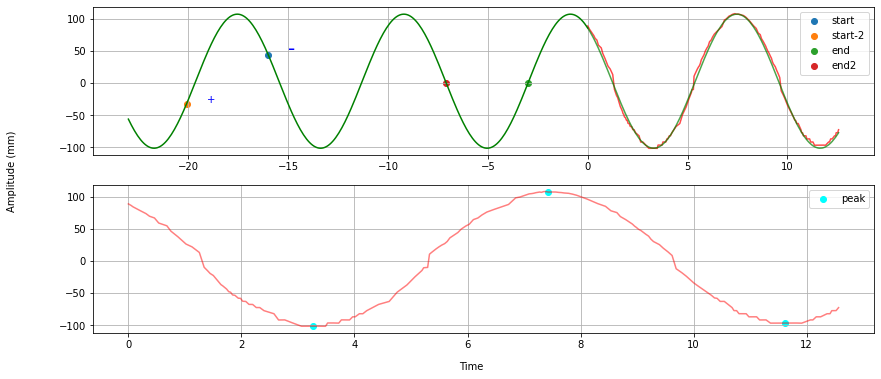

In [24]:
# 调用
estimator = SinEstimator(xs, ys)
dt = 13
solution = estimator.get_solution(dt=dt)      
# (solution_t1, solution_t2), (solution_y1, solution_y2), (sign1, sign2) = solution

# 可视化
estimator.vis_result(solution)
